<a href="https://colab.research.google.com/github/bagascahyawiguna/ImageClassification/blob/main/Dogs_VS_Cats_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klasifikasi Gambar Anjing VS Kucing**

## **Objective:**   
Membangun sebuah model menggunakan CNN yang dapat mengklasifikasikan Anjing/Kucing menggunakan gambar.

## **Sumber Dataset**
https://www.kaggle.com/datasets/salader/dogs-vs-cats

# **Import Libraries**

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# **Data Loading**

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bagascahyawiguna","key":"919cf1b143dd8591ed398e8366a5b08d"}'}

In [ ]:
# Download kaggle dataset and unzip the file
import os
os.makedirs('/root/.kaggle', exist_ok=True)

# Pindahkan dan atur permission file kaggle.json
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d salader/dogs-vs-cats

# Unzip dataset
!unzip dogs-vs-cats.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dogs/dog.4419.jpg  
  inflating: train/dogs/dog.442.jpg  
  inflating: train/dogs/dog.4420.jpg  
  inflating: train/dogs/dog.4421.jpg  
  inflating: train/dogs/dog.4422.jpg  
  inflating: train/dogs/dog.4424.jpg  
  inflating: train/dogs/dog.4425.jpg  
  inflating: train/dogs/dog.4426.jpg  
  inflating: train/dogs/dog.4427.jpg  
  inflating: train/dogs/dog.4431.jpg  
  inflating: train/dogs/dog.4433.jpg  
  inflating: train/dogs/dog.4436.jpg  
  inflating: train/dogs/dog.4438.jpg  
  inflating: train/dogs/dog.4439.jpg  
  inflating: train/dogs/dog.444.jpg  
  inflating: train/dogs/dog.4440.jpg  
  inflating: train/dogs/dog.4441.jpg  
  inflating: train/dogs/dog.4442.jpg  
  inflating: train/dogs/dog.4443.jpg  
  inflating: train/dogs/dog.4444.jpg  
  inflating: train/dogs/dog.4445.jpg  
  inflating: train/dogs/dog.4446.jpg  
  inflating: train/dogs/dog.445.jpg  
  inflating: train/dogs/dog.4450.jpg  
  inflating: tra

## **Gabungkan Data Train dan Data Test ke Direktori yang Sama**

In [ ]:
import os
import shutil

# Direktori awal untuk train dan test
train_dir = "dogs_vs_cats/train"
test_dir = "dogs_vs_cats/test"

# Direktori baru untuk dataset gabungan
combined_dir = "dogs_vs_cats/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

## **Plot gambar sampel untuk semua kelas**

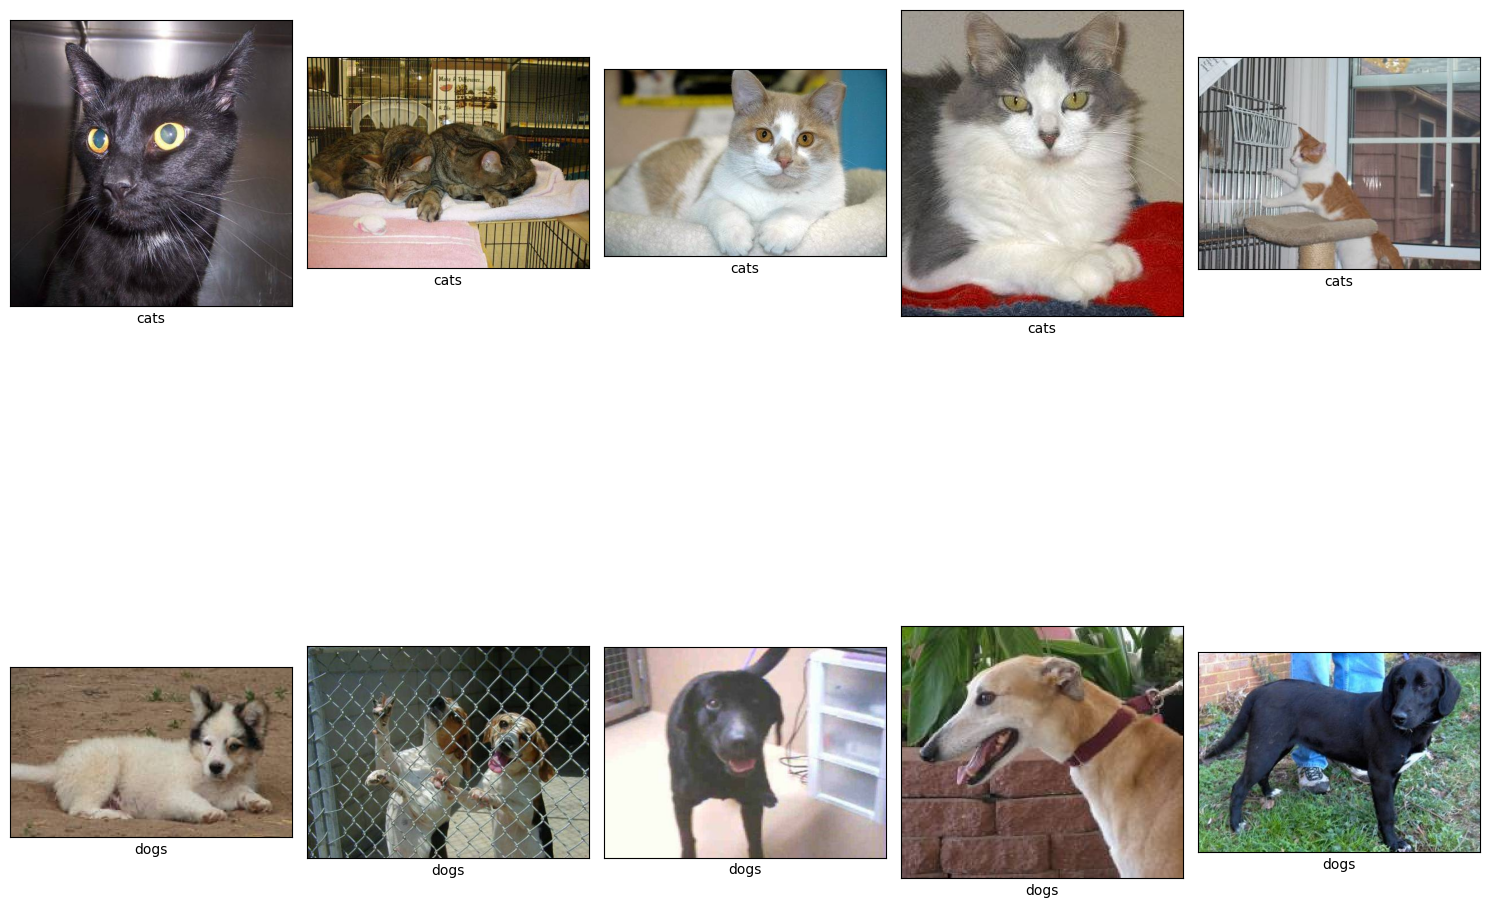

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
dog_vs_cat_image = {}

# Tentukan path sumber train
path = "dogs_vs_cats/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    dog_vs_cat_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali.
path_sub = "dogs_vs_cats/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(dog_vs_cat_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(dog_vs_cat_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

## **Plot distribusi gambar di seluruh kelas**

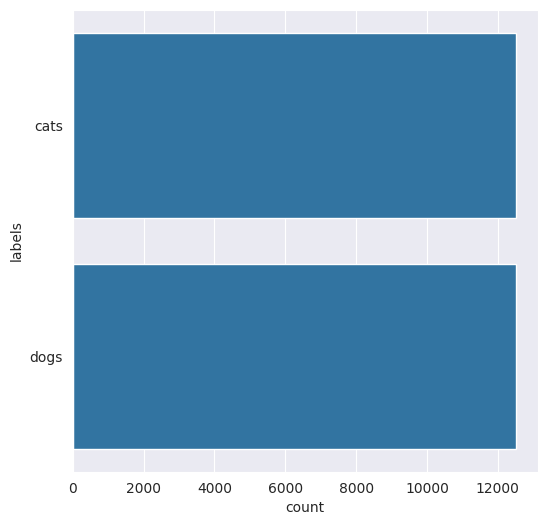

In [ ]:
# Define source path
dogs_vs_cats_path = "dogs_vs_cats/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(dogs_vs_cats_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# **Data Augmentation**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io, img_as_ubyte
import numpy as np
import random
import cv2
import os

# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))  # Sesuaikan nilai delta sesuai kebutuhan
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = tf.image.resize(img, (224, 224)).numpy()
    img = cv2.GaussianBlur(img, (3, 3), 0)
    return img

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter shearing range
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

## **Data Augmentation for "dogs" class**

In [ ]:
import os
import random
import tensorflow as tf
from skimage import io, img_as_ubyte
import cv2

# Transformasi (anggap semua fungsi sudah didefinisikan)
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

# Path asli
images_path = "dogs_vs_cats/dataset/dogs"

# Ambil semua gambar dari folder asli
images = [os.path.join(images_path, im) for im in os.listdir(images_path) if im.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Parameter augmentasi
images_to_generate = 500
i = 1
max_attempts = 10

# Augmentasi
while i <= images_to_generate:
    success = False
    attempts = 0

    while not success and attempts < max_attempts:
        image_path = random.choice(images)
        try:
            original_image = io.imread(image_path)

            if original_image.ndim not in [3, 4]:
                raise ValueError("Invalid image dimensions")

            transformed_image = original_image
            transformation_count = random.randint(1, len(transformations))

            for _ in range(transformation_count):
                key = random.choice(list(transformations))
                transformed_image = transformations[key](transformed_image)

            if isinstance(transformed_image, tf.Tensor):
                transformed_image = transformed_image.numpy()

            if transformed_image.max() > 1:
                transformed_image = transformed_image / 255.0

            transformed_image = img_as_ubyte(transformed_image)

            # Simpan hasil augmentasi ke folder asli dengan nama unik
            new_image_path = os.path.join(images_path, f"aug_image_{i}.jpg")
            cv2.imwrite(new_image_path, cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR))

            print(f"[{i}/{images_to_generate}] Saved: {new_image_path}")
            i += 1
            success = True

        except Exception as e:
            print(f"Could not read or process the image {image_path}: {e}, skipping...")
            attempts += 1

print("Augmentasi selesai!")


[1/500] Saved: dogs_vs_cats/dataset/dogs/aug_image_1.jpg
[2/500] Saved: dogs_vs_cats/dataset/dogs/aug_image_2.jpg
Could not read or process the image dogs_vs_cats/dataset/dogs/dog.10016.jpg: Images of type float must be between -1 and 1., skipping...
Could not read or process the image dogs_vs_cats/dataset/dogs/dog.7106.jpg: Images of type float must be between -1 and 1., skipping...
Could not read or process the image dogs_vs_cats/dataset/dogs/dog.4261.jpg: Images of type float must be between -1 and 1., skipping...
[3/500] Saved: dogs_vs_cats/dataset/dogs/aug_image_3.jpg
[4/500] Saved: dogs_vs_cats/dataset/dogs/aug_image_4.jpg
Could not read or process the image dogs_vs_cats/dataset/dogs/dog.6053.jpg: Images of type float must be between -1 and 1., skipping...
Could not read or process the image dogs_vs_cats/dataset/dogs/dog.6305.jpg: Images of type float must be between -1 and 1., skipping...
[5/500] Saved: dogs_vs_cats/dataset/dogs/aug_image_5.jpg
Could not read or process the imag

## **Data Augmentation for "cats" class**

In [ ]:
import os
import random
import tensorflow as tf
from skimage import io, img_as_ubyte
import cv2

# Transformasi (anggap semua fungsi sudah didefinisikan)
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

# Path asli
images_path = "dogs_vs_cats/dataset/cats"

# Ambil semua gambar dari folder asli
images = [os.path.join(images_path, im) for im in os.listdir(images_path) if im.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Parameter augmentasi
images_to_generate = 500
i = 1
max_attempts = 10

# Augmentasi
while i <= images_to_generate:
    success = False
    attempts = 0

    while not success and attempts < max_attempts:
        image_path = random.choice(images)
        try:
            original_image = io.imread(image_path)

            if original_image.ndim not in [3, 4]:
                raise ValueError("Invalid image dimensions")

            transformed_image = original_image
            transformation_count = random.randint(1, len(transformations))

            for _ in range(transformation_count):
                key = random.choice(list(transformations))
                transformed_image = transformations[key](transformed_image)

            if isinstance(transformed_image, tf.Tensor):
                transformed_image = transformed_image.numpy()

            if transformed_image.max() > 1:
                transformed_image = transformed_image / 255.0

            transformed_image = img_as_ubyte(transformed_image)

            # Simpan hasil augmentasi ke folder asli dengan nama unik
            new_image_path = os.path.join(images_path, f"aug_image_{i}.jpg")
            cv2.imwrite(new_image_path, cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR))

            print(f"[{i}/{images_to_generate}] Saved: {new_image_path}")
            i += 1
            success = True

        except Exception as e:
            print(f"Could not read or process the image {image_path}: {e}, skipping...")
            attempts += 1

print("Augmentasi selesai!")


[1/500] Saved: dogs_vs_cats/dataset/cats/aug_image_1.jpg
[2/500] Saved: dogs_vs_cats/dataset/cats/aug_image_2.jpg
[3/500] Saved: dogs_vs_cats/dataset/cats/aug_image_3.jpg
[4/500] Saved: dogs_vs_cats/dataset/cats/aug_image_4.jpg
[5/500] Saved: dogs_vs_cats/dataset/cats/aug_image_5.jpg
Could not read or process the image dogs_vs_cats/dataset/cats/cat.8837.jpg: Images of type float must be between -1 and 1., skipping...
Could not read or process the image dogs_vs_cats/dataset/cats/cat.5024.jpg: Images of type float must be between -1 and 1., skipping...
[6/500] Saved: dogs_vs_cats/dataset/cats/aug_image_6.jpg
[7/500] Saved: dogs_vs_cats/dataset/cats/aug_image_7.jpg
[8/500] Saved: dogs_vs_cats/dataset/cats/aug_image_8.jpg
[9/500] Saved: dogs_vs_cats/dataset/cats/aug_image_9.jpg
[10/500] Saved: dogs_vs_cats/dataset/cats/aug_image_10.jpg
Could not read or process the image dogs_vs_cats/dataset/cats/cat.2566.jpg: Images of type float must be between -1 and 1., skipping...
Could not read or pr

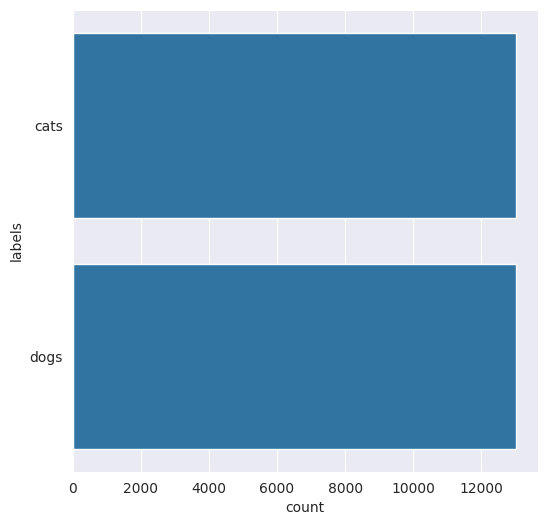

In [ ]:
# Define source path
dogs_vs_cats_path = "dogs_vs_cats/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(dogs_vs_cats_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# **Data Splitting : Training and Testing**

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'dogs_vs_cats/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
cats    13000
dogs    13000
dtype: int64

In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 20800
test size 5200


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels
test   cats       2586
       dogs       2614
train  cats      10414
       dogs      10386
dtype: int64 


                                          path labels    set
21932   dogs_vs_cats/dataset/cats/cat.7416.jpg   cats   test
15072   dogs_vs_cats/dataset/cats/cat.8130.jpg   cats  train
4676   dogs_vs_cats/dataset/cats/cat.11540.jpg   cats  train
15642  dogs_vs_cats/dataset/dogs/dog.10449.jpg   dogs  train
1586    dogs_vs_cats/dataset/cats/cat.1111.jpg   cats  train


In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "dogs_vs_cats/dataset/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# **Image Data Generator**


In [ ]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_dogs = os.path.join(TRAIN_DIR + '/dogs')
train_cats = os.path.join(TRAIN_DIR + '/cats')
test_dogs = os.path.join(TEST_DIR + '/dogs')
test_cats = os.path.join(TEST_DIR + '/cats')

print("Total number of dogs images in training set: ",len(os.listdir(train_dogs)))
print("Total number of cats images in training set: ",len(os.listdir(train_cats)))
print("Total number of dogs images in test set: ",len(os.listdir(test_dogs)))
print("Total number of cats images in test set: ",len(os.listdir(test_cats)))

Total number of dogs images in training set:  10386
Total number of cats images in training set:  10414
Total number of dogs images in test set:  2614
Total number of cats images in test set:  2586


In [ ]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              class_mode='binary',
                                              color_mode='rgb',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   class_mode='binary',
                                                   color_mode='rgb',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  class_mode='binary',
                                                  color_mode='rgb',
                                                  shuffle=False)

Found 16641 images belonging to 2 classes.
Found 4159 images belonging to 2 classes.
Found 5200 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

# **Model Exp 1 - CNN Architecture (Using 32 Neurons in Conv Layer):**

## **Modelling**

In [ ]:
tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_1.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


## **Model Training**

In [ ]:
count_dogs, count_cats = len(os.listdir(train_dogs)), len(os.listdir(train_cats))
weight_0 = (1 / count_dogs) * (count_dogs + count_cats) / 2.0
weight_1 = (1 / count_cats) * (count_cats + count_dogs) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


521/521 ━━━━━━━━━━━━━━━━━━━━ 46s 75ms/step - accuracy: 0.5511 - loss: 1.2644 - val_accuracy: 0.5881 - val_loss: 0.7223
Epoch 2/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.6807 - loss: 0.6077 - val_accuracy: 0.6792 - val_loss: 0.5760
Epoch 3/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.7633 - loss: 0.5006 - val_accuracy: 0.7420 - val_loss: 0.7999
Epoch 4/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 35s 66ms/step - accuracy: 0.8136 - loss: 0.4258 - val_accuracy: 0.7290 - val_loss: 0.5374
Epoch 5/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 44s 72ms/step - accuracy: 0.8445 - loss: 0.3692 - val_accuracy: 0.7836 - val_loss: 0.6597
Epoch 6/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 35s 67ms/step - accuracy: 0.8627 - loss: 0.3300 - val_accuracy: 0.7473 - val_loss: 0.5235
Epoch 7/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - accuracy: 0.8826 - loss: 0.2974 - val_accuracy: 0.7579 - val_loss: 0.5146
Epoch 8/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.8994 - loss: 0.2602 - val_accurac

## **Accuracy & Loss Model Plot**

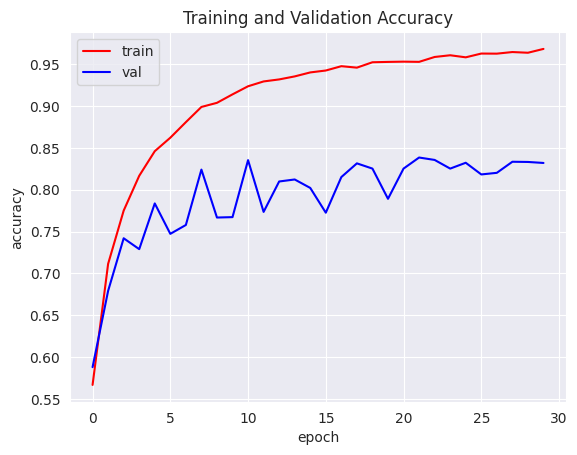

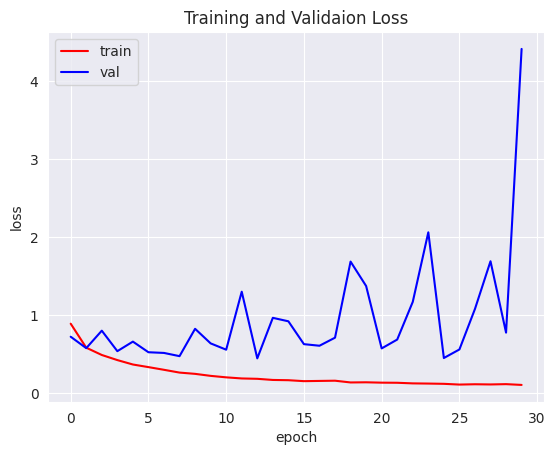

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## **F1-Score**



              precision    recall  f1-score   support

        Dogs     0.8818    0.8588    0.8702      2614
        Cats     0.8610    0.8836    0.8721      2586

    accuracy                         0.8712      5200
   macro avg     0.8714    0.8712    0.8711      5200
weighted avg     0.8714    0.8712    0.8711      5200



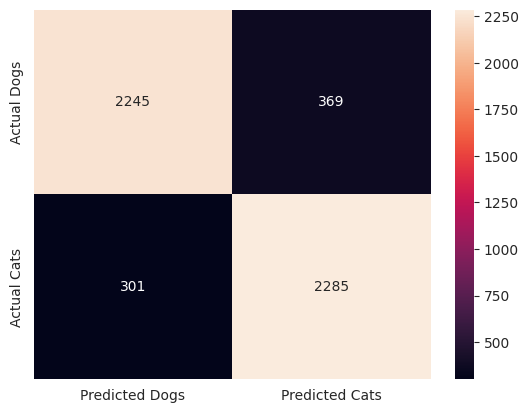

In [ ]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual Dogs", "Actual Cats"],
columns=["Predicted Dogs", "Predicted Cats"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Dogs','Cats'], digits=4))

# **Model Exp 2 - CNN Architecture Using 64 Neurons in Conv Layer:**


## **Modelling**

In [ ]:
tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_2 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_2.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_2.add(Conv2D(64, (4, 4),padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_2.add(Conv2D(64, (7, 7), padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# Flatten layer
model_2.add(Flatten())
# 1nd Dense Layer
model_2.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_2.add(Dropout(0.5))
# 2nd Dense Layer
model_2.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_2.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_2.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_2.compile(optimizer=tf.keras.optimizers.RMSprop(),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

# Summary of the Model Architecture
print(model_2.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,931,585 (11.18 MB)

 Trainable params: 2,931,201 (11.18 MB)

 Non-trainable params: 384 (1.50 KB)

None


## **Model Training**

In [ ]:
count_dogs, count_cats = len(os.listdir(train_dogs)), len(os.listdir(train_cats))
weight_0 = (1 / count_dogs) * (count_dogs + count_cats) / 2.0
weight_1 = (1 / count_cats) * (count_cats + count_dogs) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_2 = model_2.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
Epoch 1/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.5382 - loss: 1.8539 - val_accuracy: 0.5052 - val_loss: 0.6919
Epoch 2/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 38s 72ms/step - accuracy: 0.5773 - loss: 0.6833 - val_accuracy: 0.6533 - val_loss: 0.7087
Epoch 3/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 37s 72ms/step - accuracy: 0.6761 - loss: 0.6108 - val_accuracy: 0.6410 - val_loss: 0.7726
Epoch 4/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 37s 71ms/step - accuracy: 0.7376 - loss: 0.5378 - val_accuracy: 0.7572 - val_loss: 0.4996
Epoch 5/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 37s 71ms/step - accuracy: 0.7787 - loss: 0.4729 - val_accuracy: 0.7329 - val_loss: 0.5306
Epoch 6/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.8102 - loss: 0.4187 - val_accuracy: 0.7995 - val_loss: 0.4635
Epoch 7/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - accuracy: 0.8422 - loss: 0.3739 - val_accuracy: 0.8093 - val_loss: 0.4349
Epoch 8/30
521/521 ━━━━━━━

## **Accuracy & Loss Model Plot**

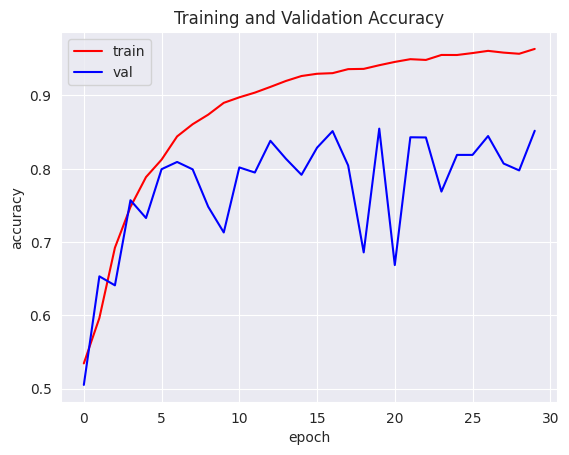

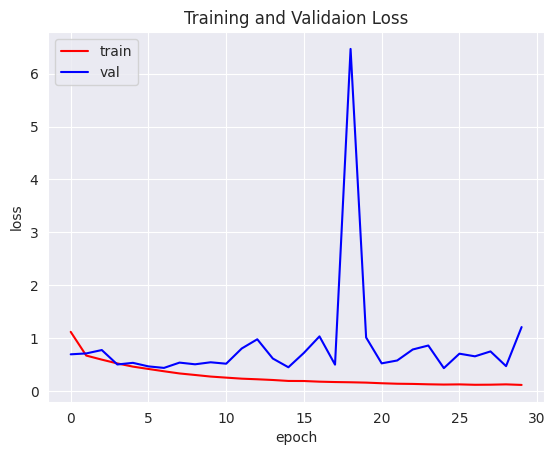

In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## **F1-Score**



              precision    recall  f1-score   support

        Dogs     0.8919    0.8432    0.8669      2614
        Cats     0.8498    0.8968    0.8726      2586

    accuracy                         0.8698      5200
   macro avg     0.8709    0.8700    0.8697      5200
weighted avg     0.8710    0.8698    0.8697      5200



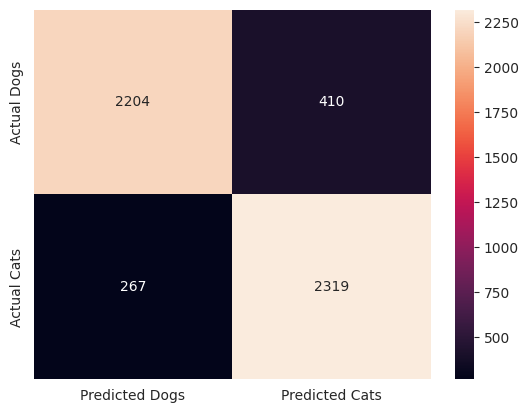

In [ ]:
test_generator.reset()

preds_2 = model_2.predict(test_generator,verbose=0)
preds_2 = preds_2.copy()
preds_2[preds_2 <= 0.5] = 0
preds_2[preds_2 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_2, labels=[0, 1]),index=["Actual Dogs", "Actual Cats"],
columns=["Predicted Dogs", "Predicted Cats"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_2,target_names =['Dogs','Cats'], digits=4))

# **Model Exp 3 - CNN Architecture Using 128 Neurons in Conv Layer:**




## **Modelling**

In [ ]:
tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_3 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_3.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_3.add(Conv2D(128, (4, 4),padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_3.add(Conv2D(128, (7, 7), padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# Flatten layer
model_3.add(Flatten())
# 1nd Dense Layer
model_3.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_3.add(Dropout(0.5))
# 2nd Dense Layer
model_3.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_3.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_3.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_3.compile(optimizer=tf.keras.optimizers.RMSprop(),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

# Summary of the Model Architecture
print(model_3.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,384,897 (24.36 MB)

 Trainable params: 6,384,129 (24.35 MB)

 Non-trainable params: 768 (3.00 KB)

None


## **Model Training**

In [ ]:
count_dogs, count_cats = len(os.listdir(train_dogs)), len(os.listdir(train_cats))
weight_0 = (1 / count_dogs) * (count_dogs + count_cats) / 2.0
weight_1 = (1 / count_cats) * (count_cats + count_dogs) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_3 = model_3.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


521/521 ━━━━━━━━━━━━━━━━━━━━ 88s 143ms/step - accuracy: 0.5228 - loss: 3.8451 - val_accuracy: 0.5042 - val_loss: 0.7115
Epoch 2/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 67s 129ms/step - accuracy: 0.4963 - loss: 0.7013 - val_accuracy: 0.5008 - val_loss: 0.6939
Epoch 3/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 80s 125ms/step - accuracy: 0.5079 - loss: 0.6937 - val_accuracy: 0.5004 - val_loss: 0.6941
Epoch 4/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 62s 119ms/step - accuracy: 0.5088 - loss: 0.6945 - val_accuracy: 0.5006 - val_loss: 0.6937
Epoch 5/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 66s 126ms/step - accuracy: 0.5072 - loss: 0.6940 - val_accuracy: 0.4992 - val_loss: 0.7160
Epoch 6/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 61s 118ms/step - accuracy: 0.5011 - loss: 0.6967 - val_accuracy: 0.5304 - val_loss: 0.6905
Epoch 7/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 84s 121ms/step - accuracy: 0.5066 - loss: 0.6990 - val_accuracy: 0.5112 - val_loss: 0.6991
Epoch 8/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 62s 119ms/step - accuracy: 0.5118 - loss: 0.6940 - val

## **Accuracy & Loss Model Plot**

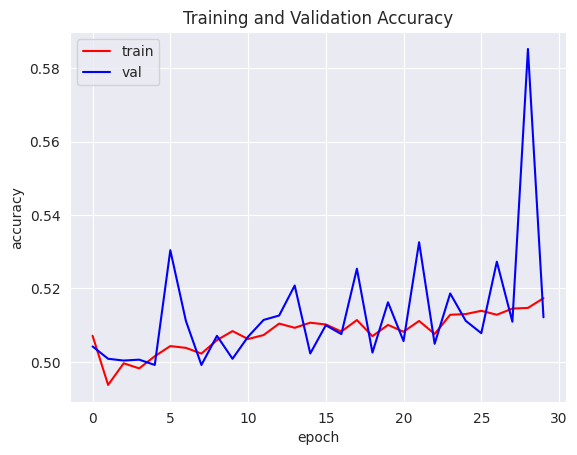

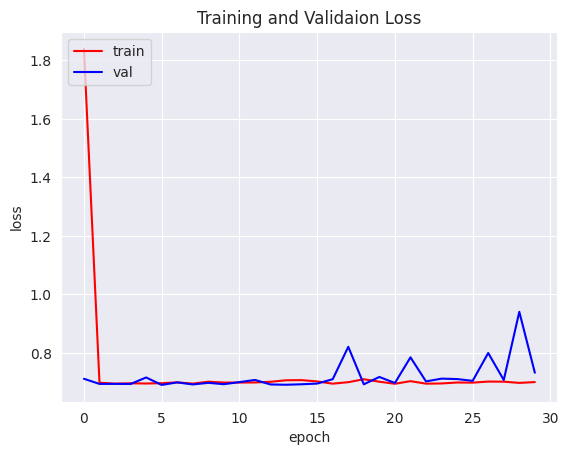

In [ ]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## **F1-Score**

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()




              precision    recall  f1-score   support

        Dogs     0.8351    0.0310    0.0598      2614
        Cats     0.5036    0.9938    0.6685      2586

    accuracy                         0.5098      5200
   macro avg     0.6693    0.5124    0.3641      5200
weighted avg     0.6702    0.5098    0.3625      5200



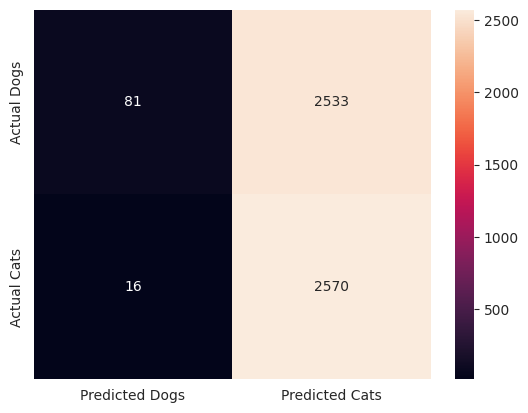

In [ ]:
test_generator.reset()

preds_3 = model_3.predict(test_generator,verbose=0)
preds_3 = preds_3.copy()
preds_3[preds_3 <= 0.5] = 0
preds_3[preds_3 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_3, labels=[0, 1]),index=["Actual Dogs", "Actual Cats"],
columns=["Predicted Dogs", "Predicted Cats"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_3,target_names =['Dogs','Cats'], digits=4))

# **Model Exp 4 - CNN Architecture (Using Learning Rate 0.001):**

## **Modelling**

In [ ]:
tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_4 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_4.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_4.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_4.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2, 2)))

# Flatten layer
model_4.add(Flatten())
# 1nd Dense Layer
model_4.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_4.add(Dropout(0.5))
# 2nd Dense Layer
model_4.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_4.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_4.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_4.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

# Summary of the Model Architecture
print(model_4.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


## **Model Training**

In [ ]:
count_dogs, count_cats = len(os.listdir(train_dogs)), len(os.listdir(train_cats))
weight_0 = (1 / count_dogs) * (count_dogs + count_cats) / 2.0
weight_1 = (1 / count_cats) * (count_cats + count_dogs) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_4 = model_4.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
Epoch 1/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.5452 - loss: 1.2784 - val_accuracy: 0.6220 - val_loss: 0.6473
Epoch 2/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - accuracy: 0.6618 - loss: 0.6235 - val_accuracy: 0.7031 - val_loss: 0.6312
Epoch 3/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 33s 64ms/step - accuracy: 0.7639 - loss: 0.4985 - val_accuracy: 0.6485 - val_loss: 1.1738
Epoch 4/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.8172 - loss: 0.4178 - val_accuracy: 0.7860 - val_loss: 0.5843
Epoch 5/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.8507 - loss: 0.3672 - val_accuracy: 0.7276 - val_loss: 0.8965
Epoch 6/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.8720 - loss: 0.3174 - val_accuracy: 0.5864 - val_loss: 1.0724
Epoch 7/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 33s 62ms/step - accuracy: 0.8754 - loss: 0.2958 - val_accuracy: 0.7264 - val_loss: 0.9768
Epoch 8/30
521/521 ━━━━━━━

## **Accuracy & Loss Model Plot**

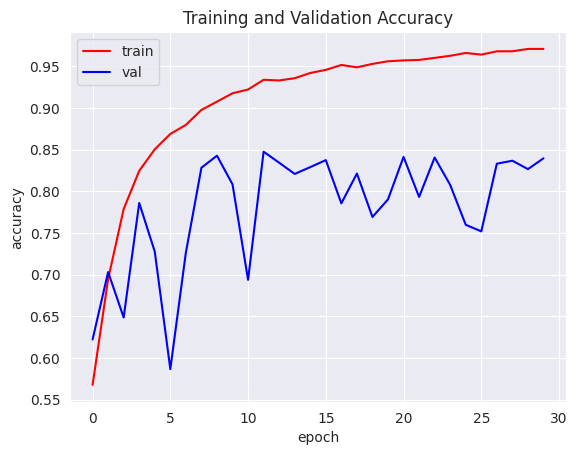

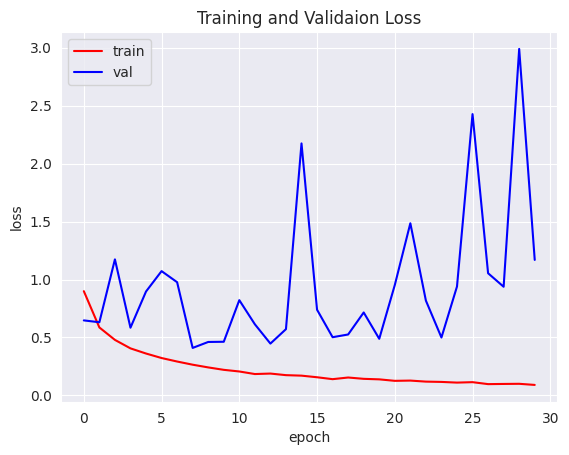

In [ ]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## **F1-Score**



              precision    recall  f1-score   support

        Dogs     0.8711    0.8554    0.8632      2614
        Cats     0.8564    0.8720    0.8642      2586

    accuracy                         0.8637      5200
   macro avg     0.8637    0.8637    0.8637      5200
weighted avg     0.8638    0.8637    0.8636      5200



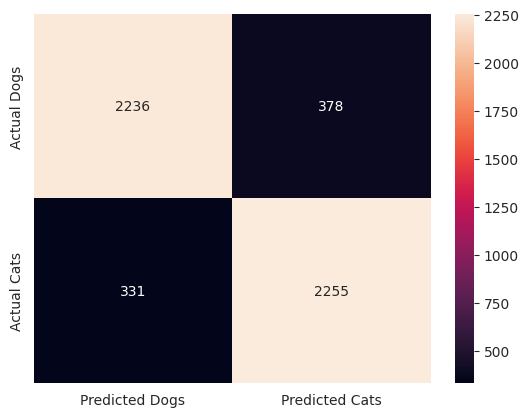

In [ ]:
test_generator.reset()

preds_4 = model_4.predict(test_generator,verbose=0)
preds_4 = preds_4.copy()
preds_4[preds_4 <= 0.5] = 0
preds_4[preds_4 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_4, labels=[0, 1]),index=["Actual Dogs", "Actual Cats"],
columns=["Predicted Dogs", "Predicted Cats"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_4,target_names =['Dogs','Cats'], digits=4))

# **Model Exp 5 - CNN Architecture (Using Learning Rate 0.0001):**


## **Modelling**

In [ ]:
tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_5 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_5.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_5.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_5.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D((2, 2)))

# Flatten layer
model_5.add(Flatten())
# 1nd Dense Layer
model_5.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_5.add(Dropout(0.5))
# 2nd Dense Layer
model_5.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_5.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_5.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_5.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_5.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


## **Model Training**

In [ ]:
count_dogs, count_cats = len(os.listdir(train_dogs)), len(os.listdir(train_cats))
weight_0 = (1 / count_dogs) * (count_dogs + count_cats) / 2.0
weight_1 = (1 / count_cats) * (count_cats + count_cats) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}


%time

# Fitting / training model
history_5 = model_5.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.68 µs
Epoch 1/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - accuracy: 0.5788 - loss: 0.8063 - val_accuracy: 0.6545 - val_loss: 0.6184
Epoch 2/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.6927 - loss: 0.5925 - val_accuracy: 0.7021 - val_loss: 0.5695
Epoch 3/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.7263 - loss: 0.5528 - val_accuracy: 0.7187 - val_loss: 0.5538
Epoch 4/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 31s 60ms/step - accuracy: 0.7581 - loss: 0.5103 - val_accuracy: 0.7199 - val_loss: 0.5554
Epoch 5/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.7742 - loss: 0.4699 - val_accuracy: 0.7608 - val_loss: 0.5056
Epoch 6/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 40s 61ms/step - accuracy: 0.7969 - loss: 0.4457 - val_accuracy: 0.7362 - val_loss: 0.5237
Epoch 7/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.8106 - loss: 0.4207 - val_accuracy: 0.7581 - val_loss: 0.5233
Epoch 8/30
521/521 ━━━━━━━

## **Accuracy & Loss Model Plot**

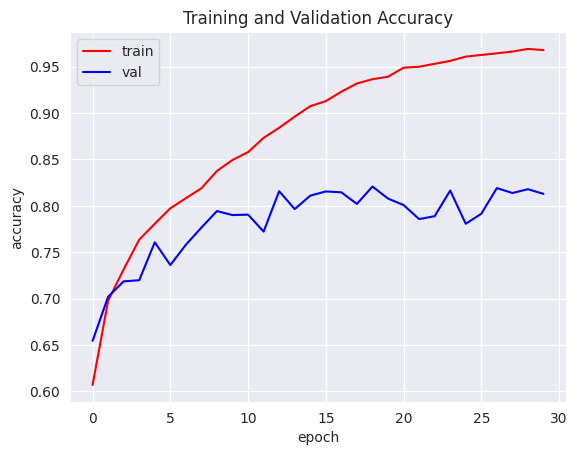

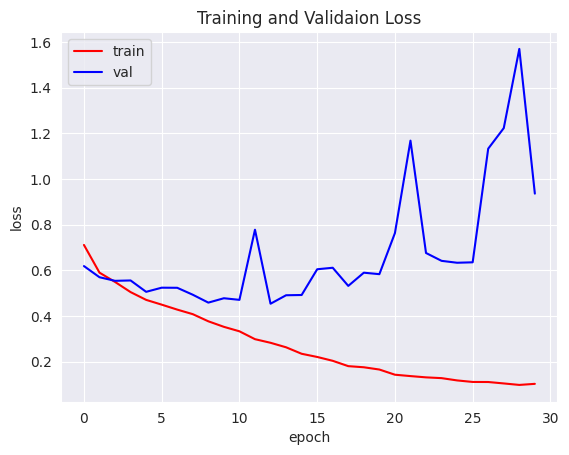

In [ ]:
acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']
loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## **F1-Score**



              precision    recall  f1-score   support

        Dogs     0.8254    0.8718    0.8480      2614
        Cats     0.8626    0.8136    0.8374      2586

    accuracy                         0.8429      5200
   macro avg     0.8440    0.8427    0.8427      5200
weighted avg     0.8439    0.8429    0.8427      5200



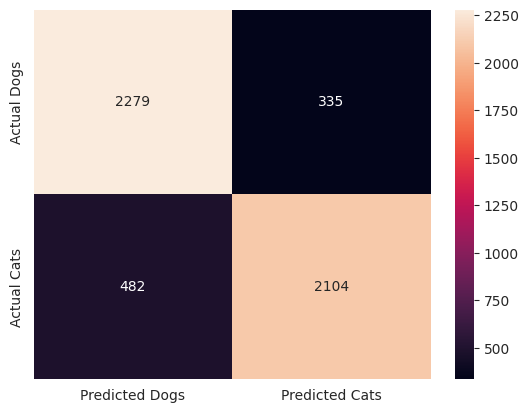

In [ ]:
test_generator.reset()

preds_5 = model_5.predict(test_generator,verbose=0)
preds_5 = preds_5.copy()
preds_5[preds_5 <= 0.5] = 0
preds_5[preds_5 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_5, labels=[0, 1]),index=["Actual Dogs", "Actual Cats"],
columns=["Predicted Dogs", "Predicted Cats"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_5,target_names =['Dogs','Cats'], digits=4))

# **Model Exp 6 - CNN Architecture (Using Learning Rate 0.00001):**

## **Modelling**

In [ ]:
tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_6 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_6.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_6.add(BatchNormalization())
model_6.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_6.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_6.add(BatchNormalization())
model_6.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_6.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_6.add(BatchNormalization())
model_6.add(MaxPooling2D((2, 2)))

# Flatten layer
model_6.add(Flatten())
# 1nd Dense Layer
model_6.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_6.add(Dropout(0.5))
# 2nd Dense Layer
model_6.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_6.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_6.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_6.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_6.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


## **Model Training**

In [ ]:
count_dogs, count_cats = len(os.listdir(train_dogs)), len(os.listdir(train_cats))
weight_0 = (1 / count_dogs) * (count_dogs + count_cats) / 2.0
weight_1 = (1 / count_cats) * (count_cats + count_dogs) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_6 = model_6.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
Epoch 1/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.5289 - loss: 0.8993 - val_accuracy: 0.5706 - val_loss: 0.6886
Epoch 2/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 37s 71ms/step - accuracy: 0.5941 - loss: 0.6943 - val_accuracy: 0.6458 - val_loss: 0.6252
Epoch 3/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.6256 - loss: 0.6509 - val_accuracy: 0.6566 - val_loss: 0.6120
Epoch 4/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 38s 72ms/step - accuracy: 0.6482 - loss: 0.6219 - val_accuracy: 0.6689 - val_loss: 0.5990
Epoch 5/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - accuracy: 0.6727 - loss: 0.6045 - val_accuracy: 0.6879 - val_loss: 0.5872
Epoch 6/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.6892 - loss: 0.5852 - val_accuracy: 0.6920 - val_loss: 0.5783
Epoch 7/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - accuracy: 0.6957 - loss: 0.5740 - val_accuracy: 0.7026 - val_loss: 0.5666
Epoch 8/30
521/521 ━━━━━━━

## **Accuracy & Loss Model Plot**

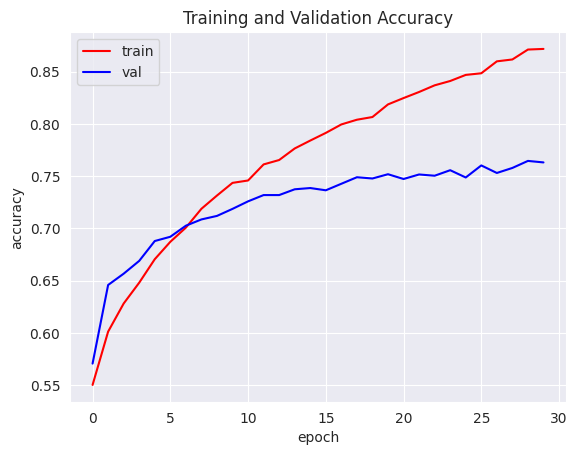

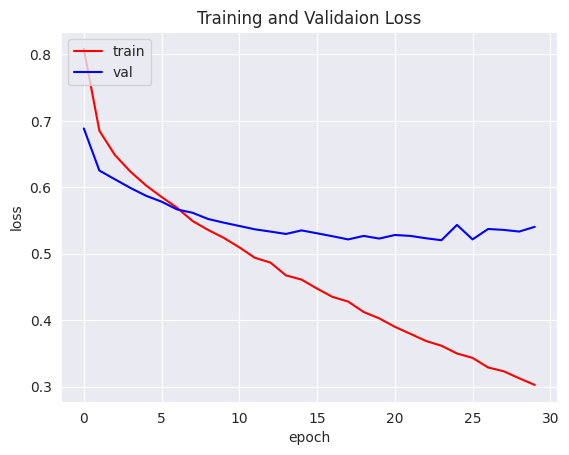

In [ ]:
acc = history_6.history['accuracy']
val_acc = history_6.history['val_accuracy']
loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## **F1-Score**



              precision    recall  f1-score   support

        Dogs     0.7988    0.7869    0.7928      2614
        Cats     0.7878    0.7997    0.7937      2586

    accuracy                         0.7933      5200
   macro avg     0.7933    0.7933    0.7933      5200
weighted avg     0.7934    0.7933    0.7933      5200



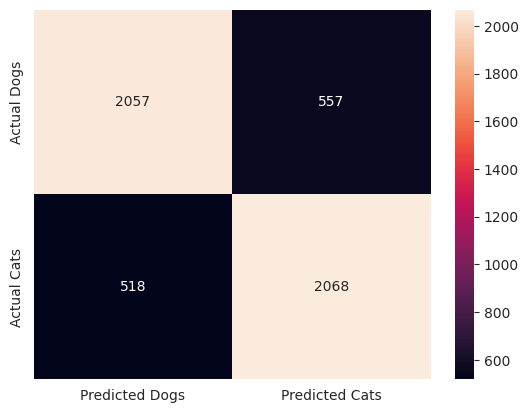

In [ ]:
test_generator.reset()

preds_6 = model_6.predict(test_generator,verbose=0)
preds_6 = preds_6.copy()
preds_6[preds_6 <= 0.5] = 0
preds_6[preds_6 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_6, labels=[0, 1]),index=["Actual Dogs", "Actual Cats"],
columns=["Predicted Dogs", "Predicted Cats"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_6,target_names =['Dogs','Cats'], digits=4))

# **Model Exp 7 - CNN Architecture (Using Adam as Optimizer):**


## **Modelling**

In [ ]:
tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_7 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_7.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_7.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_7.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D((2, 2)))

# Flatten layer
model_7.add(Flatten())
# 1nd Dense Layer
model_7.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_7.add(Dropout(0.5))
# 2nd Dense Layer
model_7.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_7.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_7.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_7.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_7.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


## **Model Training**

In [ ]:
count_dogs, count_cats = len(os.listdir(train_dogs)), len(os.listdir(train_cats))
weight_0 = (1 / count_dogs) * (count_dogs + count_cats) / 2.0
weight_1 = (1 / count_cats) * (count_cats + count_dogs) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_7 = model_7.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
Epoch 1/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 54s 105ms/step - accuracy: 0.9898 - loss: 0.0295 - val_accuracy: 0.8557 - val_loss: 0.7699
Epoch 2/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 35s 67ms/step - accuracy: 0.9882 - loss: 0.0320 - val_accuracy: 0.8288 - val_loss: 0.8755
Epoch 3/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.9869 - loss: 0.0369 - val_accuracy: 0.8387 - val_loss: 0.6000
Epoch 4/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.9862 - loss: 0.0417 - val_accuracy: 0.8473 - val_loss: 0.7051
Epoch 5/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.9916 - loss: 0.0254 - val_accuracy: 0.8492 - val_loss: 0.7404
Epoch 6/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 35s 67ms/step - accuracy: 0.9924 - loss: 0.0231 - val_accuracy: 0.8156 - val_loss: 0.7072
Epoch 7/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.9897 - loss: 0.0311 - val_accuracy: 0.7480 - val_loss: 1.6502
Epoch 8/30
521/521 ━━━━━━

## **Accuracy & Loss Model Plot**

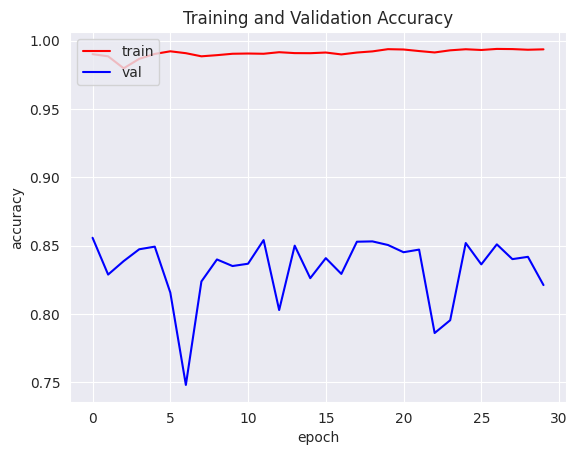

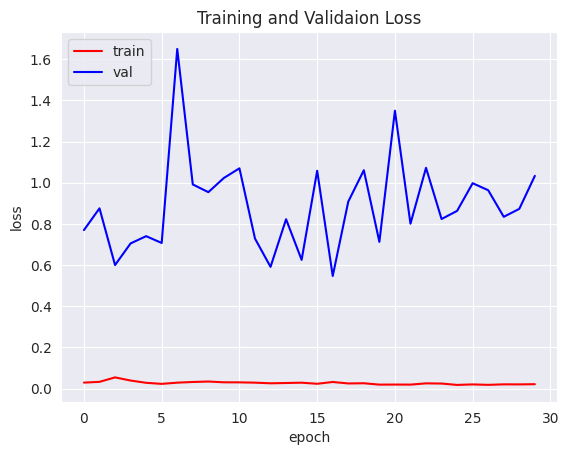

In [ ]:
acc = history_7.history['accuracy']
val_acc = history_7.history['val_accuracy']
loss = history_7.history['loss']
val_loss = history_7.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## **F1-Score**



              precision    recall  f1-score   support

        Dogs     0.8241    0.9304    0.8740      2614
        Cats     0.9191    0.7993    0.8550      2586

    accuracy                         0.8652      5200
   macro avg     0.8716    0.8648    0.8645      5200
weighted avg     0.8713    0.8652    0.8646      5200



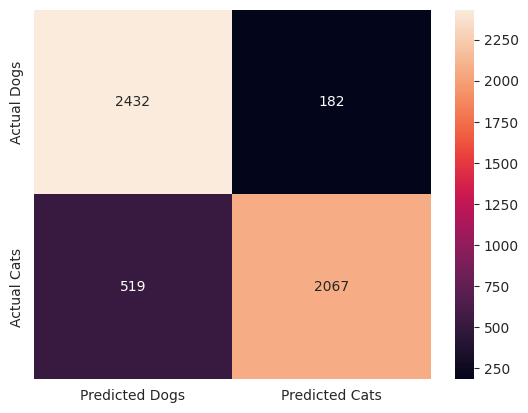

In [ ]:
test_generator.reset()

preds_7 = model_7.predict(test_generator,verbose=0)
preds_7 = preds_7.copy()
preds_7[preds_7 <= 0.5] = 0
preds_7[preds_7 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_7, labels=[0, 1]),index=["Actual Dogs", "Actual Cats"],
columns=["Predicted Dogs", "Predicted Cats"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_7,target_names =['Dogs','Cats'], digits=4))

# **Model Exp 8 - CNN Architecture (Using SGD as Optimizer):**


## **Modelling**

In [ ]:
tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_8 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_8.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_8.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_8.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D((2, 2)))

# Flatten layer
model_8.add(Flatten())
# 1nd Dense Layer
model_8.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_8.add(Dropout(0.5))
# 2nd Dense Layer
model_8.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_8.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_8.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_8.compile(optimizer=tf.keras.optimizers.SGD(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_8.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


## **Model Training**

In [ ]:
count_dogs, count_cats = len(os.listdir(train_dogs)), len(os.listdir(train_cats))
weight_0 = (1 / count_dogs) * (count_dogs + count_cats) / 2.0
weight_1 = (1 / count_cats) * (count_cats + count_dogs) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_8 = model_8.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
Epoch 1/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - accuracy: 0.5666 - loss: 0.7753 - val_accuracy: 0.6321 - val_loss: 0.6353
Epoch 2/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.6516 - loss: 0.6194 - val_accuracy: 0.6942 - val_loss: 0.5763
Epoch 3/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.7021 - loss: 0.5688 - val_accuracy: 0.5448 - val_loss: 0.7940
Epoch 4/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.7378 - loss: 0.5207 - val_accuracy: 0.5802 - val_loss: 0.9547
Epoch 5/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.7585 - loss: 0.4936 - val_accuracy: 0.6499 - val_loss: 0.6501
Epoch 6/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.7985 - loss: 0.4409 - val_accuracy: 0.7134 - val_loss: 0.5434
Epoch 7/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.8105 - loss: 0.4211 - val_accuracy: 0.7485 - val_loss: 0.5072
Epoch 8/30
521/521 ━━━━━━━

## **Accuracy & Loss Model Plot**

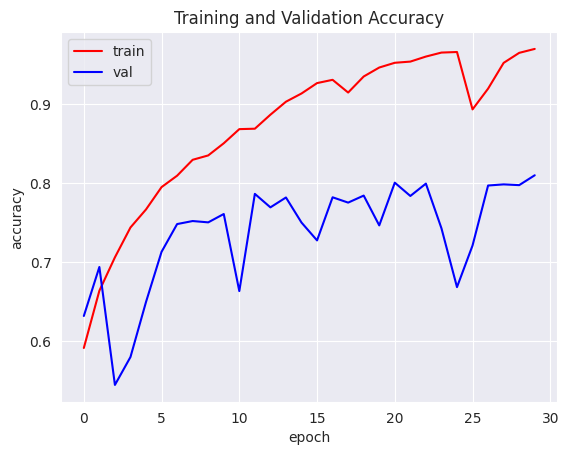

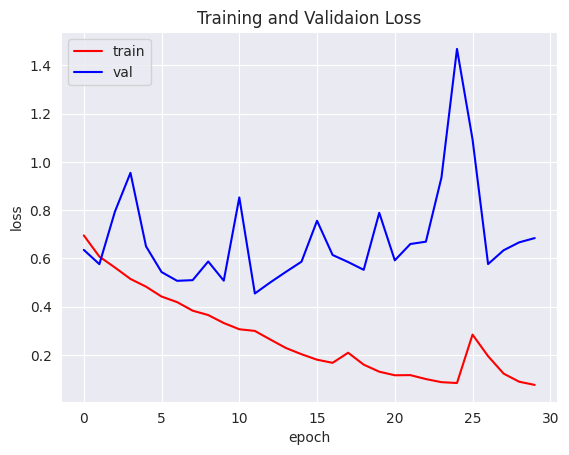

In [ ]:
acc = history_8.history['accuracy']
val_acc = history_8.history['val_accuracy']
loss = history_8.history['loss']
val_loss = history_8.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## **F1-Score**



              precision    recall  f1-score   support

        Dogs     0.8372    0.8497    0.8434      2614
        Cats     0.8457    0.8329    0.8393      2586

    accuracy                         0.8413      5200
   macro avg     0.8414    0.8413    0.8413      5200
weighted avg     0.8414    0.8413    0.8413      5200



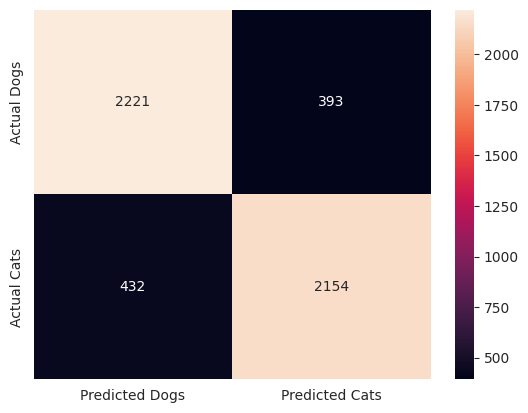

In [ ]:
test_generator.reset()

preds_8 = model_8.predict(test_generator,verbose=0)
preds_8 = preds_8.copy()
preds_8[preds_8 <= 0.5] = 0
preds_8[preds_8 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_8, labels=[0, 1]),index=["Actual Dogs", "Actual Cats"],
columns=["Predicted Dogs", "Predicted Cats"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_8,target_names =['Dogs','Cats'], digits=4))

# **Final Model**

## **Modelling**

In [ ]:
tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_final = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_final.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_final.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_final.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))

# Flatten layer
model_final.add(Flatten())
# 1nd Dense Layer
model_final.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_final.add(Dropout(0.5))
# 2nd Dense Layer
model_final.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_final.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_final.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_final.compile(optimizer=tf.keras.optimizers.RMSprop(),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

# Summary of the Model Architecture
print(model_final.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


## **Model Training**

In [ ]:
count_dogs, count_cats = len(os.listdir(train_dogs)), len(os.listdir(train_cats))
weight_0 = (1 / count_dogs) * (count_dogs + count_cats) / 2.0
weight_1 = (1 / count_cats) * (count_cats + count_dogs) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}


%time

# Fitting / training model
history_final = model_final.fit(train_generator,
                                epochs=50,
                                batch_size=32,
                                validation_data=validation_generator,
                                class_weight = class_weights)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.6 µs
Epoch 1/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.5503 - loss: 1.2825 - val_accuracy: 0.6446 - val_loss: 0.6338
Epoch 2/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.6369 - loss: 0.6479 - val_accuracy: 0.6855 - val_loss: 0.5860
Epoch 3/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 36s 69ms/step - accuracy: 0.7388 - loss: 0.5408 - val_accuracy: 0.7535 - val_loss: 0.5055
Epoch 4/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.7991 - loss: 0.4525 - val_accuracy: 0.6643 - val_loss: 0.9319
Epoch 5/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.8356 - loss: 0.3860 - val_accuracy: 0.6326 - val_loss: 0.6605
Epoch 6/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.8579 - loss: 0.3469 - val_accuracy: 0.7802 - val_loss: 0.4924
Epoch 7/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.8791 - loss: 0.3092 - val_accuracy: 0.8168 - val_loss: 0.4901
Epoch 8/50
521/521 ━━━━━━━

## **Accuracy & Loss Model Plot**

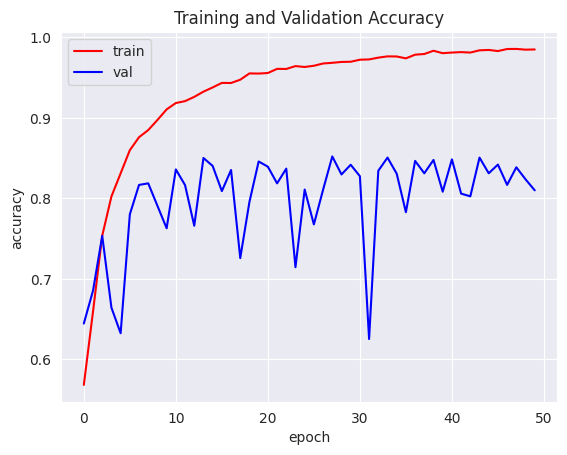

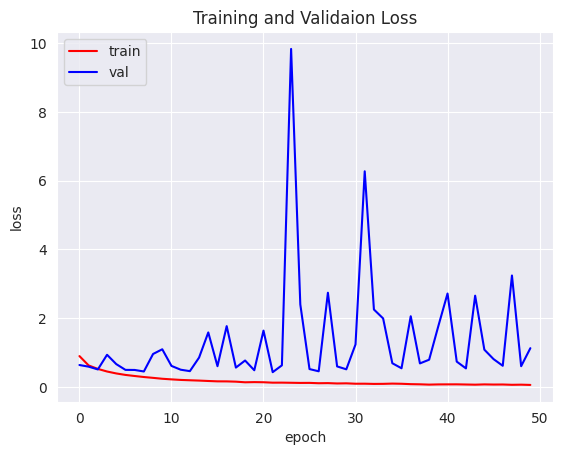

In [ ]:
acc = history_final.history['accuracy']
val_acc = history_final.history['val_accuracy']
loss = history_final.history['loss']
val_loss = history_final.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## **F1-Score**



              precision    recall  f1-score   support

        Dogs     0.8159    0.8902    0.8514      2614
        Cats     0.8778    0.7970    0.8354      2586

    accuracy                         0.8438      5200
   macro avg     0.8468    0.8436    0.8434      5200
weighted avg     0.8467    0.8438    0.8435      5200



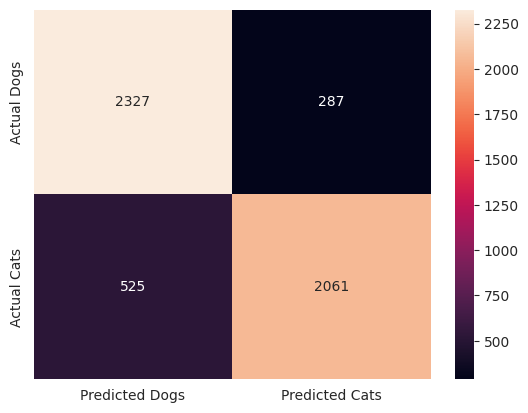

In [ ]:
test_generator.reset()

preds_final = model_final.predict(test_generator,verbose=0)
preds_final = preds_final.copy()
preds_final[preds_final <= 0.5] = 0
preds_final[preds_final > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_final, labels=[0, 1]),index=["Actual Dogs", "Actual Cats"],
columns=["Predicted Dogs", "Predicted Cats"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_final,target_names =['Dogs','Cats'], digits=4))

# **Last Model Exp**

## **Modeling**

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Input

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

last_model = Sequential([
    Input(shape=(150,150,3)),
    data_augmentation,
    Conv2D(10, kernel_size=(3,3), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),
    Conv2D(20, kernel_size=(3,3), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),
    Conv2D(40, kernel_size=(3,3), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),
    Conv2D(80, kernel_size=(3,3), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),
    Flatten(),
    Dense(80, activation='relu'),
    Dropout(0.3),
    Dense(40, activation='relu'),
    Dropout(0.3),
    Dense(20, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Kompilasi model
last_model.compile(optimizer='adamW',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

print(last_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 20)     │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 20)     │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 40)     │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 40)     │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 80)     │        28,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 80)     │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │       313,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            1

 Total params: 356,781 (1.36 MB)

 Trainable params: 356,481 (1.36 MB)

 Non-trainable params: 300 (1.17 KB)

None


## **Callback**

In [ ]:
#Callback untuk memberhentikan proses epoch ketika model tidak bisa mencapai nilai val_accuracy yang lebih tinggi

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=25, #selama 25 epoch berikutnya
    restore_best_weights=True
)

## **Model Training**

In [ ]:
count_dogs, count_cats = len(os.listdir(train_dogs)), len(os.listdir(train_cats))
weight_0 = (1 / count_dogs) * (count_dogs + count_cats) / 2.0
weight_1 = (1 / count_cats) * (count_cats + count_dogs) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}


%time

# Fitting / training model
history_last = last_model.fit(train_generator,
                                epochs=100,
                                batch_size=32,
                                validation_data=validation_generator,
                                callbacks=[early_stopping],
                                class_weight = class_weights)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


521/521 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - accuracy: 0.5169 - loss: 0.7470 - val_accuracy: 0.5061 - val_loss: 0.6889
Epoch 2/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 76s 72ms/step - accuracy: 0.5526 - loss: 0.6806 - val_accuracy: 0.6663 - val_loss: 0.6458
Epoch 3/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 38s 72ms/step - accuracy: 0.6213 - loss: 0.6542 - val_accuracy: 0.6352 - val_loss: 0.6204
Epoch 4/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.6644 - loss: 0.6192 - val_accuracy: 0.7153 - val_loss: 0.5630
Epoch 5/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 36s 69ms/step - accuracy: 0.6936 - loss: 0.5955 - val_accuracy: 0.7333 - val_loss: 0.5406
Epoch 6/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - accuracy: 0.7265 - loss: 0.5479 - val_accuracy: 0.7660 - val_loss: 0.4961
Epoch 7/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 36s 69ms/step - accuracy: 0.7537 - loss: 0.5185 - val_accuracy: 0.7711 - val_loss: 0.4843
Epoch 8/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 37s 71ms/step - accuracy: 0.7682 - loss: 0.4952 - val_

## **Accuracy & Loss Model Plot**

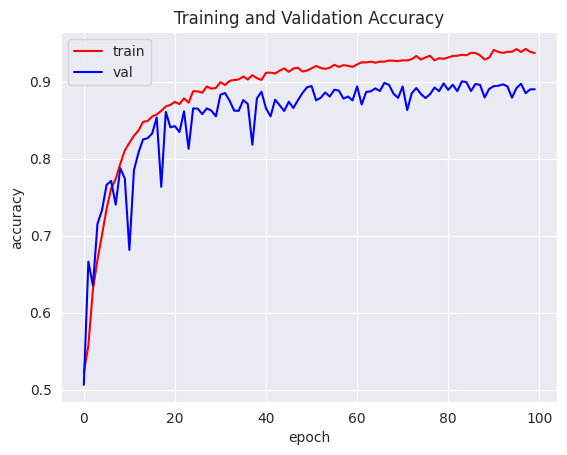

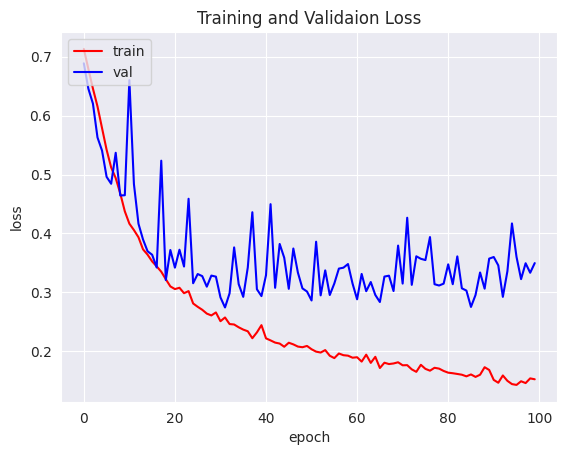

In [ ]:
acc = history_last.history['accuracy']
val_acc = history_last.history['val_accuracy']
loss = history_last.history['loss']
val_loss = history_last.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## **F1-Score for Last Model**



              precision    recall  f1-score   support

        Dogs     0.9286    0.9153    0.9219      2586
        Cats     0.9174    0.9304    0.9238      2614

    accuracy                         0.9229      5200
   macro avg     0.9230    0.9228    0.9229      5200
weighted avg     0.9230    0.9229    0.9229      5200



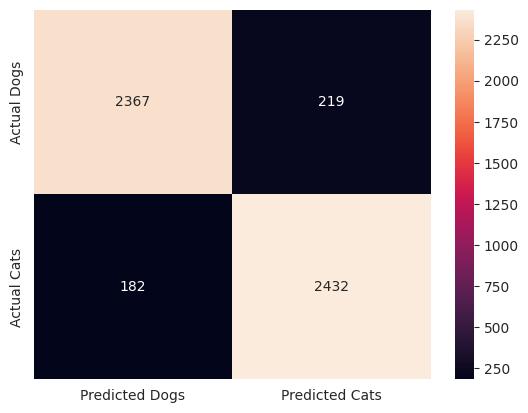

In [ ]:
test_generator.reset()

preds_last = last_model.predict(test_generator,verbose=0)
preds_last = preds_last.copy()
preds_last[preds_last <= 0.5] = 0
preds_last[preds_last > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_last, labels=[0, 1]),index=["Actual Dogs", "Actual Cats"],
columns=["Predicted Dogs", "Predicted Cats"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_last,target_names =['Dogs','Cats'], digits=4))

# **Save Best Model**

5200/5200 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step


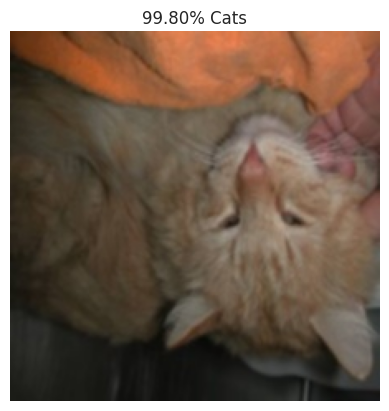

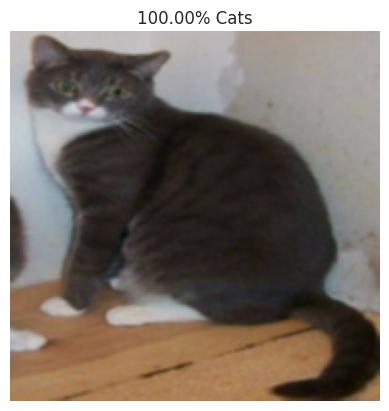

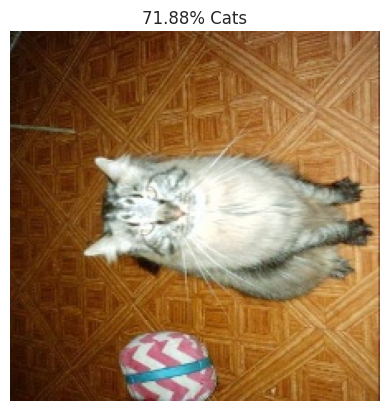

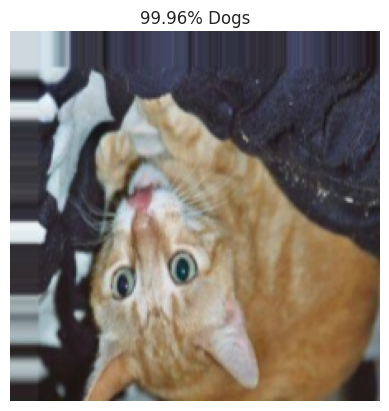

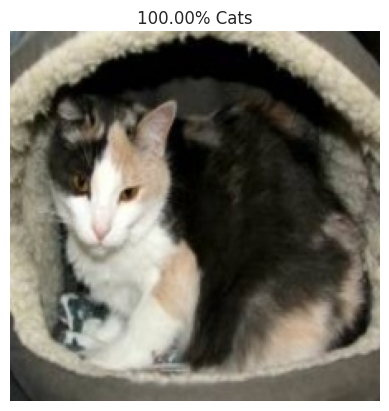

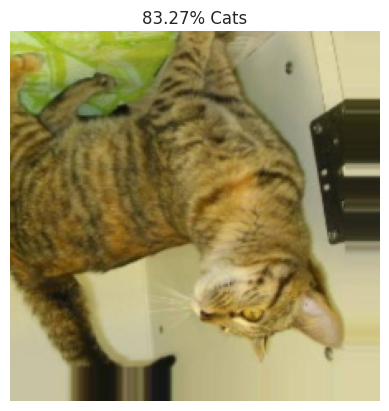

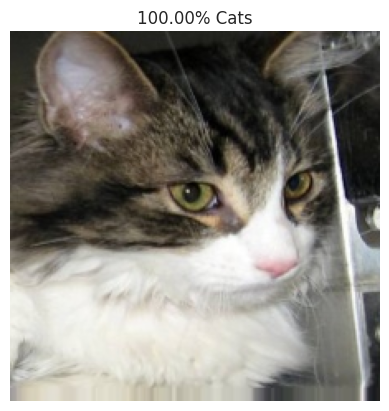

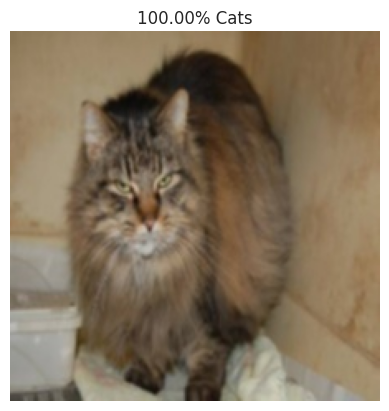

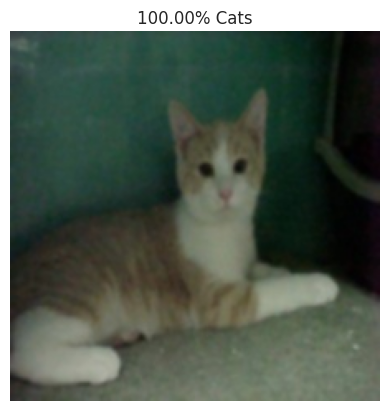

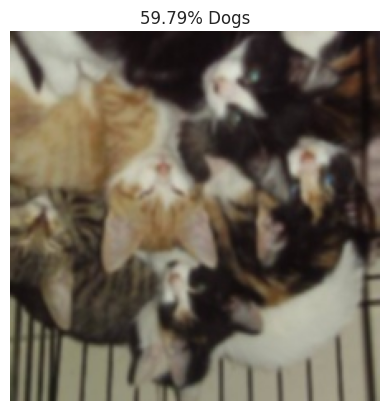

In [ ]:
# Prediksi semua gambar dalam test_generator
probabilities = last_model.predict(test_generator, verbose=1)

# Loop 10 gambar pertama
for index, probability in enumerate(probabilities[:10]):
    image_path = TEST_DIR + "/" + test_generator.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img)
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Dogs")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% Cats")
    plt.axis('off')
    plt.show()


In [ ]:
import os
import tensorflow as tf

# 1. Buat model inference dari model training
inference_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(10, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(20, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(40, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(80, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Salin bobot dari last_model
inference_model.set_weights(last_model.get_weights())

# 2. Simpan SavedModel
os.makedirs("submission/saved_model", exist_ok=True)
inference_model.export("submission/saved_model")

# 3. Simpan ke TFLite
os.makedirs("submission/tflite", exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model("submission/saved_model")
tflite_model = converter.convert()
with open("submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# 3.1 Tambah label.txt
with open("submission/tflite/label.txt", "w") as f:
    f.write("Cats\nDogs")

# 4. Konversi ke TensorFlow.js
!pip install tensorflowjs

os.makedirs("submission/tfjs_model", exist_ok=True)
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_node_names='StatefulPartitionedCall' \
    --saved_model_tags=serve \
    submission/saved_model \
    submission/tfjs_model

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_51')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136902498954576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902498955344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902498957072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902498955728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902498955152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902498956496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902498957840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902498958800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902498958992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902498958224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13690

In [ ]:
import shutil

# Membuat file zip dari folder submission
shutil.make_archive("/content/submission", 'zip', "/content/submission")

# Mengunduh file zip yang sudah dibuat
from google.colab import files
files.download("/content/submission.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **SavedModel**

In [ ]:
import shutil
from google.colab import files as colab_files  # beri alias agar tidak konflik

# Ekspor model
last_model.export("saved_model/my_model")

# Kompres ke zip
shutil.make_archive("my_model", 'zip', "saved_model/my_model")

# Unduh file zip ke komputer lokal
colab_files.download("my_model.zip")

Saved artifact at 'saved_model/my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136904631230992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136904631225232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136904631233296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136904631234640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136904631229456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136904631229264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136904631228304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136904631230416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136904631227728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136904631237136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1369046312

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **TFLite**

In [ ]:
# Buat ulang model tanpa layer augmentasi
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

# Model untuk inference (tanpa data_augmentation)
inference_model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(10, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(20, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(40, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(80, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
    Flatten(),
    Dense(80, activation='relu'),
    Dropout(0.3),
    Dense(40, activation='relu'),
    Dropout(0.3),
    Dense(20, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Salin bobot dari model aslimu (last_model)
inference_model.set_weights(last_model.get_weights())

# Simpan dalam format SavedModel
inference_model.export("saved_model/inference_model")  # Untuk TFLite & TFJS
print("✅ Model disimpan ke folder: saved_model/inference_model")

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/inference_model")
tflite_model = converter.convert()

# Simpan sebagai .tflite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)
print("✅ Model berhasil dikonversi ke TFLite: model.tflite")

# Unduh dari Colab (jika kamu pakai Google Colab)
from google.colab import files
files.download("model.tflite")

Saved artifact at 'saved_model/inference_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_28')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136902756398864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902756393488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902756400976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902756395024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902756398288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902756394448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902756397712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902756385616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902756399632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136902756399824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **TFJS**

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model \
                        --output_format=tfjs_graph_model \
                        saved_model/my_model tfjs_model/

2025-04-19 13:46:51.425642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745070411.467750   31521 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745070411.477643   31521 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-19 13:47:03.834820: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745070423.835047   31521 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
import shutil
from google.colab import files

# Kompres folder tfjs_model
shutil.make_archive("tfjs_model", 'zip', "tfjs_model")

# Download file ZIP
files.download("tfjs_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>